In [1]:
import pandas as pd
pd.set_option("display.max_columns", 100)
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

CSV_DATA = Path().cwd().parent.parent / "data/1_transformed"

In [2]:
df = pd.read_csv(CSV_DATA/'summary/ride_summary.csv')
df['start_date'] = pd.to_datetime(df['start_date'])
df['start_time'] = pd.to_timedelta(df['start_time'])
df['end_time'] = pd.to_timedelta(df['end_time'])

In [3]:
df.head()

,ride_id,start_date,start_time,end_time,biker_weight_lbs,bike_weight,bag_weight,avg_speed,avg_cruising_speed,total_ride_time_sec,total_moving_time_sec,total_distance_mi,total_ascent_ft,total_descent_ft,avg_heart_rate,avg_power,avg_cadence,avg_ambient_temp_F
0,0x5b086853,2018-05-25,0 days 19:47:31,0 days 20:27:31,220,25,5,13.720594,14.267175,2401.0,1736.0,6.991217,220.1551,237.8725,NaN,118.773678,NaN,NaN
1,0x5b3c1e5a,2018-07-04,0 days 01:09:46,0 days 01:42:05,220,25,5,13.615799,14.215438,1940.0,1737.0,6.994353,152.5665,180.1269,NaN,107.400150,NaN,NaN
2,0x5ccb413c,2019-05-02,0 days 19:13:00,0 days 19:53:00,220,25,5,13.784195,14.574504,2401.0,2143.0,8.865922,300.5396,300.5396,NaN,124.479375,NaN,NaN
3,0x5cccc63c,2019-05-03,0 days 22:52:44,0 days 23:53:54,220,25,5,11.228317,12.081964,3671.0,2725.0,9.516836,333.3496,280.1974,NaN,86.208290,NaN,NaN
4,0x5cdbff9c,2019-05-15,0 days 12:01:32,0 days 12:37:36,220,25,5,14.256866,14.701154,2165.0,1942.0,8.029630,255.2618,211.2964,NaN,132.845473,NaN,NaN


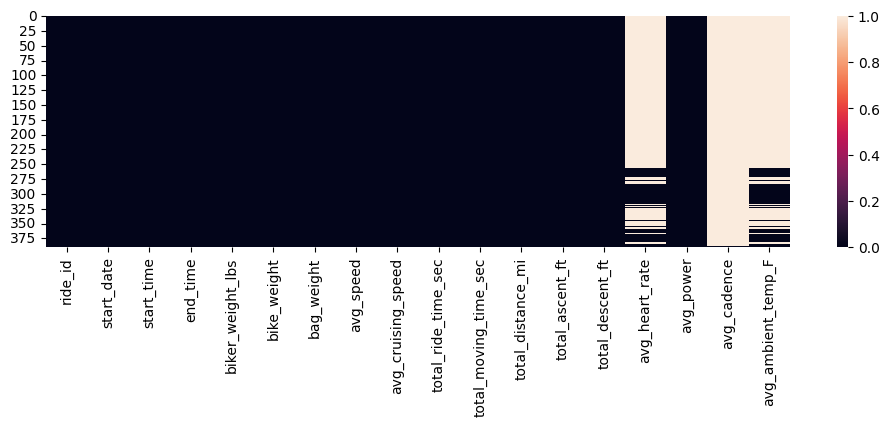

In [4]:
# Check for nulls in sensor columns
_ = plt.figure(figsize=(12,3))
_ = sns.heatmap(df.isna())

In [5]:
total_rides = df.shape[0]
rides_with_watch = total_rides - df['avg_heart_rate'].isna().sum()
percent_with_watch = 100.0* (rides_with_watch / total_rides)
print(f'Of the total {total_rides} rides, only {rides_with_watch} of them have watch sensor data ({round(percent_with_watch,2)}%)')

Of the total 390 rides, only 85 of them have watch sensor data (21.79%)


In [6]:
df['ride_year'] = df['start_date'].dt.year
df['ride_month'] = df['start_date'].dt.month
df['ride_dow'] = df['start_date'].dt.day_name()

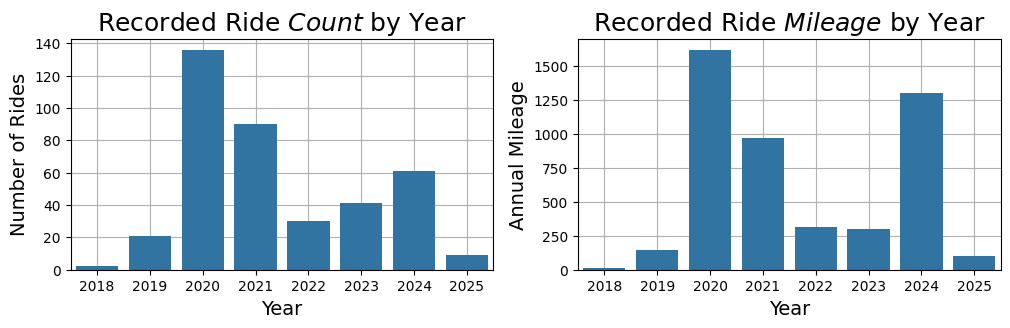

In [7]:
df_yearly_rides = df[['ride_year','total_distance_mi']].groupby('ride_year').count().rename(columns={'total_distance_mi':'ride_count'}).reset_index()
df_yearly_miles = df[['ride_year','total_distance_mi']].groupby('ride_year').sum().rename(columns={'total_distance_mi':'yearly_ride_mileage'}).reset_index()

fig, axes = plt.subplots(1,2, figsize=(12,3))
_ = sns.barplot(df_yearly_rides, x='ride_year', y='ride_count', ax=axes[0])
_ = sns.barplot(df_yearly_miles, x='ride_year', y='yearly_ride_mileage', ax=axes[1])
_ = axes[0].set_xlabel('Year', fontsize=14)
_ = axes[0].set_ylabel('Number of Rides', fontsize=14)
_ = axes[0].set_title('Recorded Ride $Count$ by Year', fontsize=18)
_ = axes[0].grid()
_ = axes[0].set_axisbelow(True)
_ = axes[1].set_xlabel('Year', fontsize=14)
_ = axes[1].set_ylabel('Annual Mileage', fontsize=14)
_ = axes[1].set_title('Recorded Ride $Mileage$ by Year', fontsize=18)
_ = axes[1].grid()
_ = axes[1].set_axisbelow(True)

In [8]:
df.total_distance_mi.sum()

4762.263833227133

## Ride Heatmap by Year

In [9]:
def get_year_activity_data_by_weekday(df:pd.DataFrame, filt_year:int, agg_column:str='total_distance_mi', agg_method:str='sum') -> pd.DataFrame:
    # Create an Aggregation of the selected column across the dates available from rides. Multiple rides can occur on a single day
    df_filt_year = df.copy().loc[df['ride_year']==filt_year,:]
    df_grouped = df_filt_year.groupby(['start_date','ride_dow'])[agg_column].agg(agg_method).reset_index()

    # Create a list of ALL dates in which rides could be done for the year
    all_year_dates = pd.DataFrame(pd.date_range(str(filt_year) + "-01-01", str(filt_year) + "-12-31", freq="D"), columns=['ride_date'])
    all_year_dates['day_of_week'] = all_year_dates['ride_date'].dt.day_name()
    df_total_dates = all_year_dates.merge(df_grouped, how='left', left_on='ride_date', right_on='start_date').fillna(0.0)
    #df_total_dates['ride_date'] = df_total_dates['ride_date'].dt.date

    return df_total_dates

    # Create a Pivot table for rides by date and dow
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    pivot_df = df_total_dates.pivot_table(index='ride_date', columns='day_of_week', values=agg_column, fill_value=0.0).reindex(columns=days_order)
    pivot_df= pivot_df.rename(columns={full:short for full,short in zip(days_order, ['M','T','W','Th','F','Sa','Su'])})

    pivot_df = pivot_df.reset_index()
    return pivot_df


In [10]:
df_activity_2020 = get_year_activity_data_by_weekday(df, filt_year=2020)
df_activity_2021 = get_year_activity_data_by_weekday(df, filt_year=2021)
df_activity_2022 = get_year_activity_data_by_weekday(df, filt_year=2022)
df_activity_2023 = get_year_activity_data_by_weekday(df, filt_year=2023)
df_activity_2024 = get_year_activity_data_by_weekday(df, filt_year=2024)

In [11]:
df_activity_2020

,ride_date,day_of_week,start_date,ride_dow,total_distance_mi
0,2020-01-01,Wednesday,0.0,0.0,0.000000
1,2020-01-02,Thursday,2020-01-02 00:00:00,Thursday,5.276248
2,2020-01-03,Friday,0.0,0.0,0.000000
3,2020-01-04,Saturday,0.0,0.0,0.000000
4,2020-01-05,Sunday,0.0,0.0,0.000000
...,...,...,...,...,...
361,2020-12-27,Sunday,0.0,0.0,0.000000
362,2020-12-28,Monday,0.0,0.0,0.000000
363,2020-12-29,Tuesday,2020-12-29 00:00:00,Tuesday,11.314947
364,2020-12-30,Wednesday,2020-12-30 00:00:00,Wednesday,9.745118


In [12]:
# cmap = plt.get_cmap('YlGn',10)
# cmap.set_under('grey')#Colour values less than vmin in grey
# cmap.set_over('green')# colour valued larger than vmax in green 

# _ = plt.figure(figsize=(10, 1.5))
# _ = sns.heatmap(df_activity_2024.set_index('ride_date').T, cmap=cmap, linewidths=0.0, linecolor='black', square=False, annot=False, cbar=False, vmin=0.005, vmax=50.0)
# _ = plt.title('Bike Ride Activity')
# _ = plt.xlabel('')
# _ = plt.ylabel('')

In [13]:
# pip install plotly-caplot 
# note: this could cause some package conflicts with numpy (previously 2.2.5) and pytz (previously  2025.2). 
# I made need to uninstall calplot to continue working as normal since calplot relies on older versions than described above
# ref: https://www.youtube.com/watch?v=U4gjFYvQafo
from plotly_calplot import calplot
# Also I need to install nbformat>=4.2.0

In [32]:
cmap = plt.get_cmap('YlGn',10)
list(sns.color_palette('YlGn',n_colors=10).as_hex())

['#f9fdc5',
 '#eaf7af',
 '#d2eda0',
 '#b1df90',
 '#8bce81',
 '#64bc6f',
 '#3fa85b',
 '#288a47',
 '#10743c',
 '#005e33']

In [48]:
colorscale = list(sns.color_palette('YlGn',n_colors=10).as_hex())
colorscale = [(x,c) for x,c in zip(np.linspace(0.0,1.0,10), colorscale)]
colorscale[0] = (0.00, "#888888")

fig = calplot(df_activity_2024, x='ride_date', y='total_distance_mi', colorscale=colorscale, 
              dark_theme=True, gap=1, month_lines_width=4, month_lines_color='#000000',
            showscale=True, total_height=225, title='Ride Mileage 2024')
fig.show()

In [49]:
fig = calplot(df_activity_2023, x='ride_date', y='total_distance_mi', colorscale=colorscale, 
              dark_theme=True, gap=1, month_lines_width=4, month_lines_color='#000000',
            showscale=True, total_height=225, title='Ride Mileage 2023')
fig.show()

In [50]:
fig = calplot(df_activity_2022, x='ride_date', y='total_distance_mi', colorscale=colorscale, 
              dark_theme=True, gap=1, month_lines_width=4, month_lines_color='#000000',
            showscale=True, total_height=225, title='Ride Mileage 2022')
fig.show()

In [51]:
fig = calplot(df_activity_2021, x='ride_date', y='total_distance_mi', colorscale=colorscale, 
              dark_theme=True, gap=1, month_lines_width=4, month_lines_color='#000000',
            showscale=True, total_height=225, title='Ride Mileage 2021')
fig.show()

In [52]:
fig = calplot(df_activity_2020, x='ride_date', y='total_distance_mi', colorscale=colorscale, 
              dark_theme=True, gap=1, month_lines_width=4, month_lines_color='#000000',
            showscale=True, total_height=225, title='Ride Mileage 2020')
fig.show()